In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
# from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from itertools import permutations 
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_recall_fscore_support, hamming_loss, jaccard_score

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import trimesh

from moduler import *

import sys
sys.path.append('/data/users2/yxiao11/mangoDB/wirehead')
from wirehead import WireheadGenerator
from wirehead import MongoTupleheadDataset, MongoheadDataset

torch.set_printoptions(sci_mode=False)


In [68]:

class get_dataset(Dataset):
    def __init__(self, data_dir, labels_dir):
        self.data_dir = data_dir
        self.labels_dir = labels_dir

    def __len__(self):
        return len(self.data_dir)

    def __getitem__(self, idx):
        
#         print(idx)
        ipt = torch.from_numpy(np.load(self.data_dir[idx]))
        ipt = ipt.permute(2, 0, 1)
        
        label_index = torch.from_numpy(np.load(self.labels_dir[idx]))-1
        
        label = torch.zeros(19)
        label[label_index] = 1
        
        return ipt.float(), label.float()
    

class CubeModel(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(CubeModel, self).__init__()
        
        self.output_dim = output_dim

        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128 → 64

#         Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64 → 32

        # Third convolutional block (new)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32 → 16

        self.dropout = nn.Dropout(p=0.1)  # Reduced dropout for stability

        # Global Average Pooling (removes dependence on input size)
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))  
        x = self.dropout(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))  
        x = self.dropout(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))  
        x = self.dropout(x)

        x = self.gap(x)  # Global Average Pooling
        x = torch.flatten(x, start_dim=1)  # Flatten before FC layer

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Final output layer (logits)
        
        return F.sigmoid(x)

#         x = x.view(-1, self.output_dim, 2)
        
#         return F.softmax(x, dim=-1)  # No sigmoid, use BCEWithLogitsLoss()
    
    
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=7):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(20, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    
class AlexNet(nn.Module):

    def __init__(self, num_classes=7):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(21, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 3 * 3)
        x = self.classifier(x)
        return F.sigmoid(x)

In [133]:
class RNNFeatureExtractor(nn.Module):
    def __init__(self, output_dim=19, dropout_prob=0.5):
        super(RNNFeatureExtractor, self).__init__()

        self.output_dim = output_dim
        self.dropout_prob = dropout_prob

        # Encoder CNN
        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(1, 16, kernel_size=9, stride=1, padding=4),  # [batch*seq, 16, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2),  # [batch*seq, 16, 16, 16]
            nn.Dropout2d(self.dropout_prob),

            nn.ConvTranspose2d(16, 32, kernel_size=9, stride=1, padding=4),  # [batch*seq, 32, 16, 16]
            nn.ReLU(),
            nn.MaxPool2d(2),  # [batch*seq, 32, 8, 8]
            nn.Dropout2d(self.dropout_prob),
        )

        # Flattened CNN feature size: 32 * 8 * 8 = 2048
        cnn_output_size = 32 * 8 * 8
        self.rnn_hidden_size = 128

        # RNN for sequence processing
        self.rnn = nn.LSTM(
            input_size=cnn_output_size,
            hidden_size=self.rnn_hidden_size,
            num_layers=1,
            batch_first=True,
#             dropout=self.dropout_prob
        )

        # Dropout after RNN
        self.rnn_dropout = nn.Dropout(self.dropout_prob)

        # Classification head (multi-label)
        self.fc_class = nn.Linear(self.rnn_hidden_size, self.output_dim)

#         # Decoder (Deconvolution for reconstruction)
#         self.decoder_fc = nn.Linear(self.rnn_hidden_size, cnn_output_size)

#         self.deconv = nn.Sequential(
#             nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # Upsample to [batch*seq, 16, 16, 16]
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),   # Upsample to [batch*seq, 1, 32, 32]
#             nn.Sigmoid()  # Assuming image reconstruction between 0-1
#         )

    def forward(self, x):
        batch_size, seq_len, h, w = x.size()

        # CNN Encoder
        x_reshaped = x.view(batch_size * seq_len, 1, h, w)
        encoded = self.cnn(x_reshaped)  # [batch*seq, 32, 8, 8]
        
        # Flatten for RNN
        features = encoded.view(batch_size, seq_len, -1)  # [batch, seq, 2048]

        # RNN Processing
        rnn_out, (h_n, c_n) = self.rnn(features)

        # Take the last hidden state
        last_hidden = rnn_out[:, -1, :]  # [batch, rnn_hidden_size]
        last_hidden_dropout = self.rnn_dropout(last_hidden)

        # Classification output (multi-label)
        class_output = torch.sigmoid(self.fc_class(last_hidden_dropout))  # [batch, output_dim]

#         # Reconstruction output
#         decoder_input = self.decoder_fc(last_hidden)  # [batch, 2048]
#         decoder_input = decoder_input.view(batch_size, 32, 8, 8)  # Reshape to feature map
#         recon_output = self.deconv(decoder_input)  # [batch, 1, 32, 32]

        return class_output

In [134]:
# # Load dataset
# # my_dataset = get_dataset(blur_file, label_file)

# # Define split ratio
# train_size = int(0.8 * len(my_dataset))  # 80% training
# test_size = len(my_dataset) - train_size  # 20% testing

# # Randomly split dataset
# train_dataset, test_dataset = random_split(my_dataset, [train_size, test_size])

# # Print dataset sizes
# print(f"Total samples: {len(my_dataset)}")
# print(f"Training samples: {len(train_dataset)}")
# print(f"Testing samples: {len(test_dataset)}")

In [148]:
# num_epochs = 100
# batch_size = 1

# # Define DataLoaders for training and testing
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle training data
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)  # No shuffle for testing

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CubeModel(52, 19).to(device)
model = RNNFeatureExtractor(19, 0.1).to(device)
# model = AlexNet(7).to(device)

# Define Loss Function and Optimizer
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.MSELoss()
# criterion = torch.nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.011, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=0.000001)




In [149]:


dataset = MongoTupleheadDataset(config_path = "/data/users2/yxiao11/mangoDB/wirehead/examples/satellite/config.yaml")



Dataset: config loaded from /data/users2/yxiao11/mangoDB/wirehead/examples/satellite/config.yaml
Dataset: Data is ready


In [150]:
batch = dataset.__getitem__([0])
cube = torch.cat([t.unsqueeze(0) for t in [b[0] for b in batch]], dim=0)
labels = torch.cat([t.unsqueeze(0) for t in [b[1] for b in batch]], dim=0)

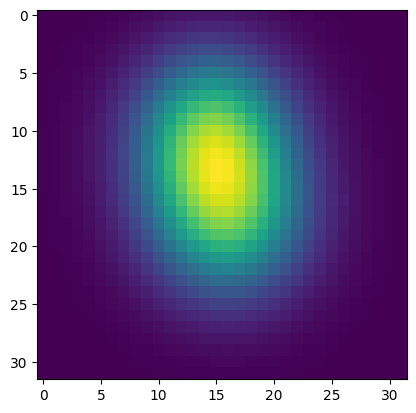

In [151]:
plt.imshow(cube[0][3].detach().numpy())

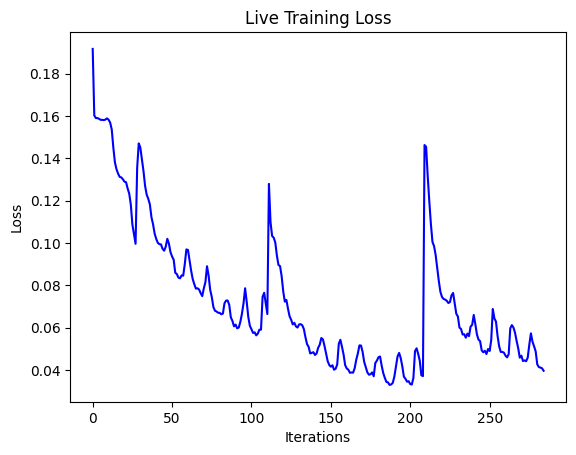

In [ ]:
from IPython.display import display, clear_output  # For updating plots in Jupyter

# Initialize lists for tracking loss
my_train_loss = []
my_test_loss = []

# Create the figure for plotting
fig, ax = plt.subplots()
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.set_title("Live Training Loss")

num_samples = dataset.__len__()
model.train()
my_loss = []
iteration = 0
step_size=40
lr_decay_factor = 0.9

batch_size = 100

num_epoch = int(num_samples/batch_size)
while True:  # Modify with a proper stopping condition (e.g., fixed number of iterations)
    
    running_loss = 0
    index = np.random.permutation(np.arange(num_samples))
    for i in range(num_epoch):   
        
        batch = dataset.__getitem__(index[i*batch_size: (i+1)*batch_size])
        cube = torch.cat([t.unsqueeze(0) for t in [b[0] for b in batch]], dim=0)
        labels = torch.cat([t.unsqueeze(0) for t in [b[1] for b in batch]], dim=0)
        cube, labels = cube.to(device, non_blocking=True).float(), labels.to(device, non_blocking=True).float()

        optimizer.zero_grad()
        outputs = model(cube)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        
    # learning rate update
    if iteration % step_size == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= lr_decay_factor
        print(f"Iteration {iteration}: Learning rate updated to {optimizer.param_groups[0]['lr']:.6f}")

    # Append the new loss
    my_loss.append(running_loss/num_epoch)

    # Print loss after each iteration
#     print(f"Iteration {iteration+1}, Loss: {loss.item():.4f}")

    # ✅ Update the plot dynamically in Jupyter Notebook
    clear_output(wait=True)  # Clear previous plot to update dynamically
    ax.clear()  # Clear the axis to redraw
    ax.plot(my_loss, label="Training Loss", color="blue")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")
    ax.set_title("Live Training Loss")
#     ax.legend()
    display(fig)  # Re-display updated plot

    iteration += 1


In [ ]:
# my_train_loss = []
# my_test_loss = []
# num_epochs=300
# for epoch in range(num_epochs):
#     # Training Phase
#     model.train()
#     running_loss = 0.0

#     for cube, labels in train_loader:
#         cube, labels = cube.to(device), labels.to(device)

#         # Zero gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         outputs = model(cube)
#         loss = criterion(outputs, labels)
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
#         scheduler.step()
        
#         running_loss += loss.item()

#     avg_train_loss = running_loss / len(train_loader)
#     my_train_loss.append(avg_train_loss)
    
#     # Testing Phase
#     model.eval()
#     test_loss = 0.0


#     with torch.no_grad():  # Disable gradients for validation/testing
#         for cube, labels in test_loader:
#             cube, labels = cube.to(device), labels.to(device)
            
#             # Forward pass
#             outputs = model(cube)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item()
            

#     avg_test_loss = test_loss / len(test_loader)
#     my_test_loss.append(avg_test_loss)
    
#     # Print results for this epoch
#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


In [ ]:
# my_train_loss = []
# my_test_loss = []

# for epoch in range(num_epochs):
#     # Training Phase
#     model.train()
#     running_loss = 0.0
#     for batch_idx, (cube, labels) in enumerate(train_loader):
#         cube, labels = cube.to(device), labels.to(device)
#         # Zero gradients
#         optimizer.zero_grad()
#         # Forward pass
#         outputs = model(cube)
#         loss = criterion(outputs, labels)
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
        
#     avg_train_loss = running_loss / len(train_loader)
#     my_train_loss.append(avg_train_loss)

#     # Testing Phase
#     model.eval()
#     test_loss = 0.0

#     with torch.no_grad():
#         for batch_idx, (cube, labels) in enumerate(test_loader):
#             cube, labels = cube.to(device), labels.to(device)
            
#             # Forward pass
#             outputs = model(cube)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item()

#     avg_test_loss = test_loss / len(test_loader)
#     my_test_loss.append(avg_test_loss)



#     # Print results for this epoch
#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")



In [ ]:
# torch.save(model, f"/data/users2/yxiao11/model/satellite_project/resluts_n_model/{data_type}.pth")
# print("Entire model saved!")

In [111]:
data_type = 'mixed'
# data_type = 'Pristine'
# data_type = 'Irradiated'

blur_dir = '/data/users2/yxiao11/model/satellite_project/data/' +data_type + '/blur_cube/'
spectral_dir = '/data/users2/yxiao11/model/satellite_project/data/' +data_type + '/spectral_cube/'
label_dir = '/data/users2/yxiao11/model/satellite_project/data/' +data_type + '/label/'

blur_file = []
label_file = []
spectral_file = []
for i in range(len(os.listdir(blur_dir))):
    blur_file.append(blur_dir + f"{i}.npy")
    label_file.append(label_dir + f"{i}.npy")
    spectral_file.append(spectral_dir + f"{i}.npy")
    
# Load dataset
my_dataset = get_dataset(blur_file, label_file)




# Define split ratio
train_size = int(0.1 * len(my_dataset))  # 10% training
test_size = len(my_dataset) - train_size  # 90% testing

# Randomly split dataset
train_dataset, test_dataset = random_split(my_dataset, [train_size, test_size])

# Print dataset sizes
print(f"Total samples: {len(my_dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    

model.eval()
label_list = []
preds_list = []

with torch.no_grad():
    for batch_idx, (cube, labels) in enumerate(test_loader):
        cube, labels = cube.to(device), labels.to(device)

        # Forward pass
        outputs = torch.round(model(cube)).cpu()
        labels = labels.cpu()
        
#         for i in range(batch_size):
#             label_list.append(torch.argmin(labels[0], dim=1).detach().numpy())
#             preds_list.append(torch.argmin(outputs[0], dim=1).detach().numpy())
            
        
        for i in range(batch_size):
            label_list.append(labels[i].detach().numpy())
            preds_list.append(outputs[i].detach().numpy())

Total samples: 1000
Training samples: 100
Testing samples: 900


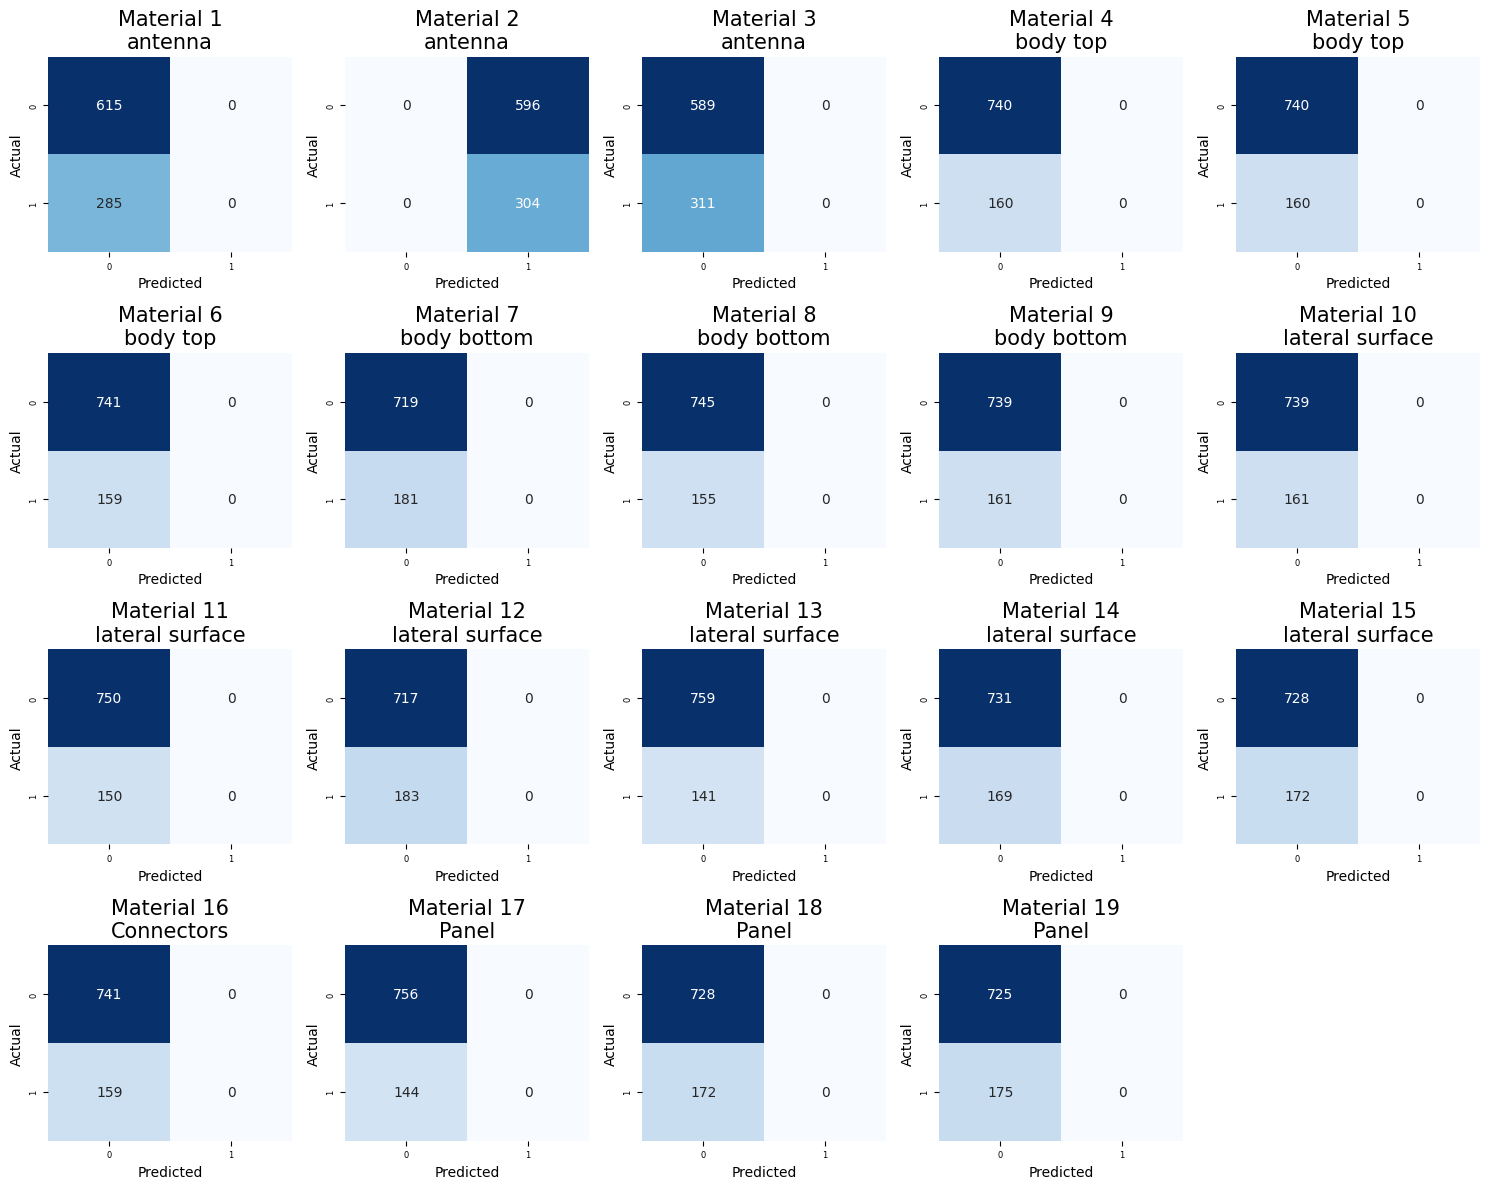

/data/users2/yxiao11/anaconda3/envs/p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hamming Loss: 0.2219
Macro F1-Score: 0.0266
Micro F1-Score: 0.1381
Jaccard Similarity Score: 0.0874


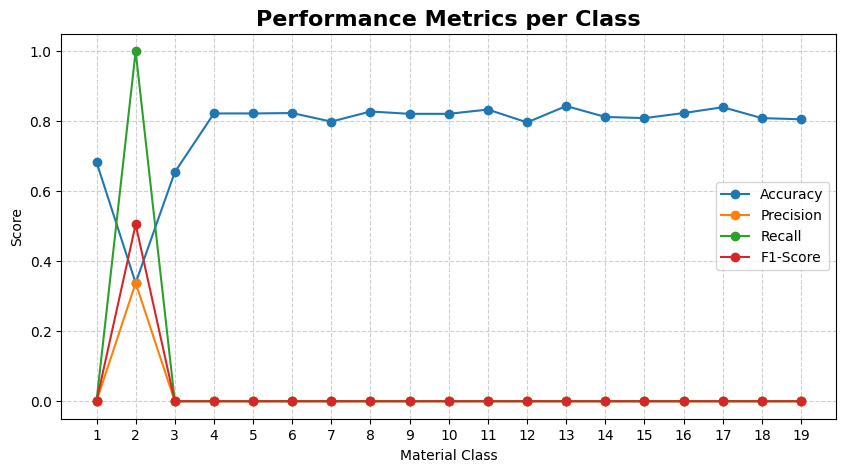

In [112]:

part_list = ['antenna', 'antenna', 'antenna',
            'body top', 'body top', 'body top',
             'body bottom', 'body bottom', 'body bottom',
             'lateral surface', 'lateral surface','lateral surface',
             'lateral surface','lateral surface','lateral surface',
             'Connectors', 'Panel', 'Panel', 'Panel'
            ]

# Stack predictions and true labels
y_true = np.vstack(label_list)  # True labels (multi-label)
y_pred = np.vstack(preds_list)  # Predicted labels

# Compute multi-label confusion matrices (one per class)
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

# 📌 **1️⃣ Better Confusion Matrix Layout (Grid instead of Single Row)**
num_classes = len(conf_matrices)  # Should be 19
cols = 5  # Set number of columns for grid
rows = (num_classes // cols) + (num_classes % cols > 0)  # Auto adjust rows

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))  # Dynamic grid size
axes = axes.flatten()  # Flatten grid for easy indexing

for i, cm in enumerate(conf_matrices):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Material {i+1}\n{part_list[i]}", fontsize=15)
    axes[i].set_xlabel("Predicted", fontsize=10)
    axes[i].set_ylabel("Actual", fontsize=10)
    axes[i].tick_params(axis='both', labelsize=6)

# Hide unused subplots (in case 19 is not a perfect grid)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Compute classification metrics
accuracy_per_class = np.mean(y_true == y_pred, axis=0)  # Per-class accuracy
hamming = hamming_loss(y_true, y_pred)  # Hamming loss
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)  # Per-class metrics
macro_f1 = np.mean(f1)  # Macro F1-score
micro_f1 = precision_recall_fscore_support(y_true, y_pred, average="micro")[2]  # Micro F1-score
jaccard = jaccard_score(y_true, y_pred, average="samples")  # Jaccard similarity

# Display Metrics
print(f"Hamming Loss: {hamming:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Micro F1-Score: {micro_f1:.4f}")
print(f"Jaccard Similarity Score: {jaccard:.4f}")

# Plot accuracy, precision, recall, and F1-score per class
metrics = {"Accuracy": accuracy_per_class, "Precision": precision, "Recall": recall, "F1-Score": f1}
fig, ax = plt.subplots(figsize=(10, 5))

for metric, values in metrics.items():
    ax.plot(range(1, len(values)+1), values, marker="o", label=metric)

ax.set_xticks(np.arange(19)+1)
ax.set_xlabel("Material Class")
ax.set_ylabel("Score")
ax.set_title("Performance Metrics per Class",fontsize=16, fontweight="bold")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
# data_type = 'mixed'
data_type = 'Pristine'
# data_type = 'Irradiated'

blur_dir = '/data/users2/yxiao11/model/satellite_project/data/' +data_type + '/blur_cube/'
spectral_dir = '/data/users2/yxiao11/model/satellite_project/data/' +data_type + '/spectral_cube/'
label_dir = '/data/users2/yxiao11/model/satellite_project/data/' +data_type + '/label/'

blur_file = []
label_file = []
spectral_file = []
for i in range(len(os.listdir(blur_dir))):
    blur_file.append(blur_dir + f"{i}.npy")
    label_file.append(label_dir + f"{i}.npy")
    spectral_file.append(spectral_dir + f"{i}.npy")
    
# Load dataset
my_dataset = get_dataset(blur_file, label_file)

# Define split ratio
train_size = int(0.8 * len(my_dataset))  # 80% training
test_size = len(my_dataset) - train_size  # 20% testing

# Randomly split dataset
train_dataset, test_dataset = random_split(my_dataset, [train_size, test_size])

# Print dataset sizes
print(f"Total samples: {len(my_dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

In [5]:
data_type = 'mixed'
# data_type = 'Pristine'
# data_type = 'Irradiated'

model = torch.load(f"/data/users2/yxiao11/model/satellite_project/resluts_n_model/{data_type}.pth")
model.eval()
model.to(device)

/tmp/ipykernel_2268667/2649455779.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"/data/users2/yxiao11/model/satellite_project/resluts_n_model/{data

CubeModel(
  (conv1): Conv2d(21, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=38, bias=True)
)

In [6]:
batch_size = 1
num_samples = dataset.__len__()
model.train()
my_loss = []
iteration = 0

num_epoch = int(num_samples/batch_size)
# while True:  # Modify with a proper stopping condition (e.g., fixed number of iterations)
    
running_loss = 0
index = np.random.permutation(np.arange(num_samples))
for i in range(num_epoch):   
#     print(i)
    batch = dataset.__getitem__(index[i*batch_size: (i+1)*batch_size])
    cube = torch.cat([t.unsqueeze(0) for t in [b[0] for b in batch]], dim=0)
    labels = torch.cat([t.unsqueeze(0) for t in [b[1] for b in batch]], dim=0)
    cube, labels = cube.to(device, non_blocking=True), labels.to(device, non_blocking=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

322

In [14]:
batch = dataset.__getitem__([int(np.random.choice(index))])
cube = torch.cat([t.unsqueeze(0) for t in [b[0] for b in batch]], dim=0)
labels = torch.cat([t.unsqueeze(0) for t in [b[1] for b in batch]], dim=0)
cube, labels = cube.to(device, non_blocking=True), labels.to(device, non_blocking=True)

In [15]:
torch.round(model(cube))

tensor([[[0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.]]], device='cuda:0', grad_fn=<RoundBackward0>)

In [16]:
labels

tensor([[[1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.]]], device='cuda:0', dtype=torch.float64)

In [ ]:
model.eval()
label_list = []
preds_list = []

with torch.no_grad():
    for batch_idx, (cube, labels) in enumerate(test_loader):
        cube, labels = cube.to(device), labels.to(device)

        # Forward pass
        outputs = torch.round(model(cube)).cpu()
        labels = labels.cpu()
        
        for i in range(batch_size):
            label_list.append(labels[i].detach().numpy())
            preds_list.append(outputs[i].detach().numpy())


In [ ]:
my_train_loss = np.load(f"/data/users2/yxiao11/model/satellite_project/resluts_n_model/{data_type}_train_loss.npy")
        
my_test_loss = np.load(f"/data/users2/yxiao11/model/satellite_project/resluts_n_model/{data_type}_test_loss.npy")

In [ ]:
# Function to smooth the loss curve using Exponential Moving Average (EMA)
def smooth_curve(data, weight=0.9):
    smoothed = []
    last = data[0]  # Initialize with the first value
    for point in data:
        last = weight * last + (1 - weight) * point  # EMA formula
        smoothed.append(last)
    return smoothed

# Smooth both training and test loss
smooth_train_loss = smooth_curve(my_train_loss, weight=0.9)
smooth_test_loss = smooth_curve(my_test_loss, weight=0.9)

# Create the figure
plt.figure(figsize=(20, 5))

# Plot original training loss (faint color)
plt.plot(my_train_loss, label="Train Loss (Original)", color="royalblue", alpha=0.3, linewidth=1)

# Plot smoothed training loss
plt.plot(smooth_train_loss, label="Train Loss (Smoothed)", color="royalblue", linewidth=2)

# Plot original test loss (faint color)
plt.plot(my_test_loss, label="Test Loss (Original)", color="darkorange", alpha=0.3, linewidth=1, linestyle="--")

# Plot smoothed test loss
plt.plot(smooth_test_loss, label="Test Loss (Smoothed)", color="darkorange", linewidth=2, linestyle="--")

# Improve visualization
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title(f"{data_type}", fontsize=16, fontweight="bold")
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)  # Add grid for better readability


# Show the plot
plt.show()

In [ ]:

part_list = ['antenna', 'antenna', 'antenna',
            'body top', 'body top', 'body top',
             'body bottom', 'body bottom', 'body bottom',
             'lateral surface', 'lateral surface','lateral surface',
             'lateral surface','lateral surface','lateral surface',
             'Connectors', 'Panel', 'Panel', 'Panel'
            ]

# Stack predictions and true labels
y_true = np.vstack(label_list)  # True labels (multi-label)
y_pred = np.vstack(preds_list)  # Predicted labels

# Compute multi-label confusion matrices (one per class)
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

# 📌 **1️⃣ Better Confusion Matrix Layout (Grid instead of Single Row)**
num_classes = len(conf_matrices)  # Should be 19
cols = 5  # Set number of columns for grid
rows = (num_classes // cols) + (num_classes % cols > 0)  # Auto adjust rows

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))  # Dynamic grid size
axes = axes.flatten()  # Flatten grid for easy indexing

for i, cm in enumerate(conf_matrices):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Material {i+1}\n{part_list[i]}", fontsize=15)
    axes[i].set_xlabel("Predicted", fontsize=10)
    axes[i].set_ylabel("Actual", fontsize=10)
    axes[i].tick_params(axis='both', labelsize=6)

# Hide unused subplots (in case 19 is not a perfect grid)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Compute classification metrics
accuracy_per_class = np.mean(y_true == y_pred, axis=0)  # Per-class accuracy
hamming = hamming_loss(y_true, y_pred)  # Hamming loss
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)  # Per-class metrics
macro_f1 = np.mean(f1)  # Macro F1-score
micro_f1 = precision_recall_fscore_support(y_true, y_pred, average="micro")[2]  # Micro F1-score
jaccard = jaccard_score(y_true, y_pred, average="samples")  # Jaccard similarity

# Display Metrics
print(f"Hamming Loss: {hamming:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Micro F1-Score: {micro_f1:.4f}")
print(f"Jaccard Similarity Score: {jaccard:.4f}")

# Plot accuracy, precision, recall, and F1-score per class
metrics = {"Accuracy": accuracy_per_class, "Precision": precision, "Recall": recall, "F1-Score": f1}
fig, ax = plt.subplots(figsize=(10, 5))

for metric, values in metrics.items():
    ax.plot(range(1, len(values)+1), values, marker="o", label=metric)

ax.set_xticks(np.arange(19)+1)
ax.set_xlabel("Material Class")
ax.set_ylabel("Score")
ax.set_title("Performance Metrics per Class",fontsize=16, fontweight="bold")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_recall_fscore_support, hamming_loss, jaccard_score

# Define material categories
part_list = [
    'Antenna', 'Antenna', 'Antenna',
    'Body Top', 'Body Top', 'Body Top',
    'Body Bottom', 'Body Bottom', 'Body Bottom',
    'Lateral Surface', 'Lateral Surface', 'Lateral Surface',
    'Lateral Surface', 'Lateral Surface', 'Lateral Surface',
    'Connectors', 'Panel', 'Panel', 'Panel'
]

# Stack predictions and true labels
y_true = np.vstack(label_list)  # True labels (multi-label)
y_pred = np.vstack(preds_list)  # Predicted labels

# Compute multi-label confusion matrices (one per class)
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

# 📌 **1️⃣ Better Confusion Matrix Layout (Grid View)**
num_classes = len(conf_matrices)  
cols = 5  
rows = (num_classes // cols) + (num_classes % cols > 0)  

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()  

for i, cm in enumerate(conf_matrices):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Material {i+1}\n{part_list[i]}", fontsize=15)
    axes[i].set_xlabel("Predicted", fontsize=10)
    axes[i].set_ylabel("Actual", fontsize=10)
    axes[i].tick_params(axis='both', labelsize=6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 📌 **2️⃣ Compute Classification Metrics with Clearer Names**
accuracy_per_class = np.mean(y_true == y_pred, axis=0)  # Accuracy per class
hamming = hamming_loss(y_true, y_pred)  # Average label error rate
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)  # Per-class scores
macro_f1 = np.mean(f1)  # Overall Class Balance Score
micro_f1 = precision_recall_fscore_support(y_true, y_pred, average="micro")[2]  # Weighted Class Balance Score
jaccard = jaccard_score(y_true, y_pred, average="samples")  # Label Overlap Score

# 📌 **3️⃣ Print More Understandable Metrics**
print(f"Average Label Error Rate (Hamming Loss): {hamming:.4f}")
print(f"Overall Class Balance Score (Macro F1-Score): {macro_f1:.4f}")
print(f"Weighted Class Balance Score (Micro F1-Score): {micro_f1:.4f}")
print(f"Label Overlap Score (Jaccard Similarity Score): {jaccard:.4f}")

# 📌 **4️⃣ Plot Metrics for Each Class**
metrics = {
    "Accuracy per Material": accuracy_per_class,
    "Label Correctness Rate (Precision)": precision,
    "Label Coverage Rate (Recall)": recall,
    "Prediction Quality Score (F1-Score)": f1
}

fig, ax = plt.subplots(figsize=(10, 5))

for metric, values in metrics.items():
    ax.plot(range(1, len(values)+1), values, marker="o", label=metric)

ax.set_xticks(np.arange(len(part_list))+1)
ax.set_xticklabels(part_list, rotation=45, ha="right", fontsize=9)
ax.set_xlabel("Material Type", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("📊 Performance Metrics per Material", fontsize=16, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [ ]:
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for cube, labels in train_loader:
#         cube, labels = cube.to(device), labels.to(device)

#         # Zero gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         outputs = model(cube)
#         loss = criterion(outputs, labels)
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
#         scheduler.step()
        
#         running_loss += loss.item()

#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


In [ ]:
# model.eval()  # Set model to evaluation mode
# total_test_loss = 0

# with torch.no_grad():  # No gradient calculation during testing
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         total_test_loss += loss.item()

# print(f"Test Loss: {total_test_loss/len(test_loader):.4f}")

In [ ]:
model(sample_data)

In [ ]:
sample_data, label = next(iter(test_loader))
sample_data = sample_data.to(device)

In [ ]:
print(torch.round(model(sample_data)))

print(torch.round(model(sample_data)) - label.to(device))

In [ ]:
to_show = (torch.round(model(sample_data)) - label.to(device)).cpu().detach().numpy()
plt.imshow(to_show)

In [ ]:
i = 1
# m = np.load('/Users/yaorongxiao/Desktop/satellite/spectral_cube.npy')
m = np.load(f'./data/sim_data/spectral_cube/{i}.npy')

print(np.load(f'./data/sim_data/label/{i}.npy'))


In [ ]:
%matplotlib inline
fig, ax = plt.subplots(21,1, figsize=(10,100))

for i in range(21):
    ax[i].imshow(m[:,:,i])